In [ ]:
#|default_exp init_lsuv

# Initialization

In [ ]:
%env PYTORCH_ENABLE_MPS_FALLBACK 1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)


In [ ]:
from miniai.mps import *

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
xmean,xstd = 0.28, 0.35
bs=1024

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
tds = cache_dataset_as_dict(tds)

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
xb,yb = next(iter(dls.train))

In [ ]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.01))

In [ ]:
from miniai.init import GeneralRelu, plot_func, init_weights

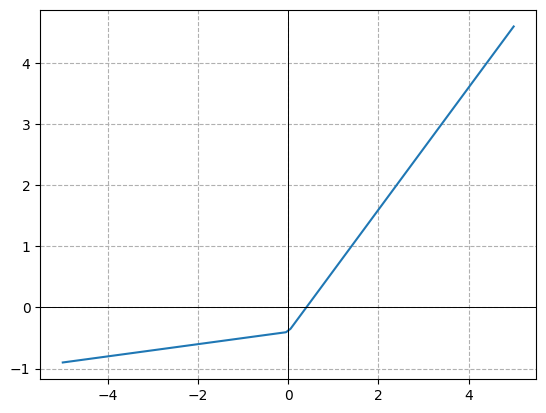

In [ ]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [ ]:
init_weights??

In [ ]:

reseed = ReseedCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance((GeneralRelu, nn.ReLU, nn.GELU)))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

accuracy,loss,epoch,train
0.776,0.627,0,train
0.842,0.428,0,eval


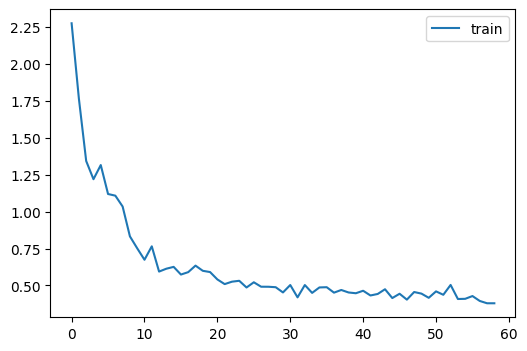

In [ ]:
set_seed(10)
reseed.set_seed(42)
model = get_model(act_gr).to('cpu').apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

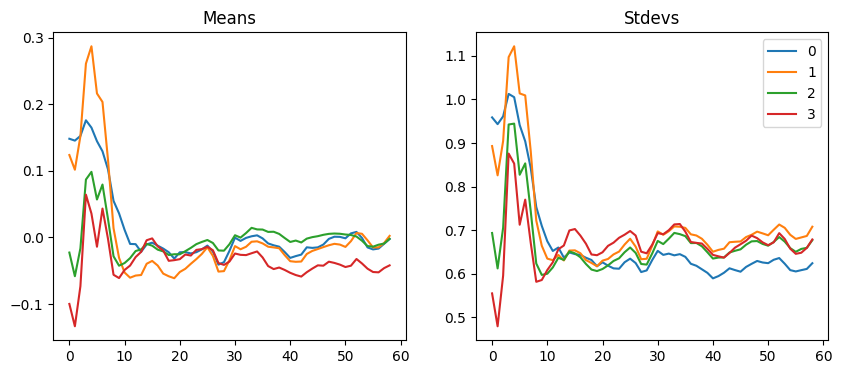

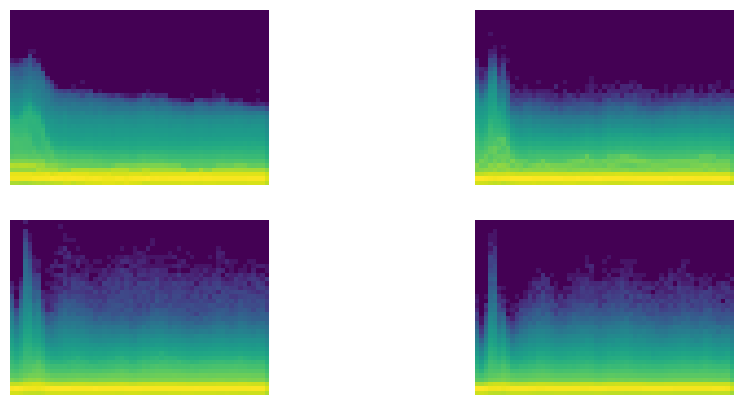

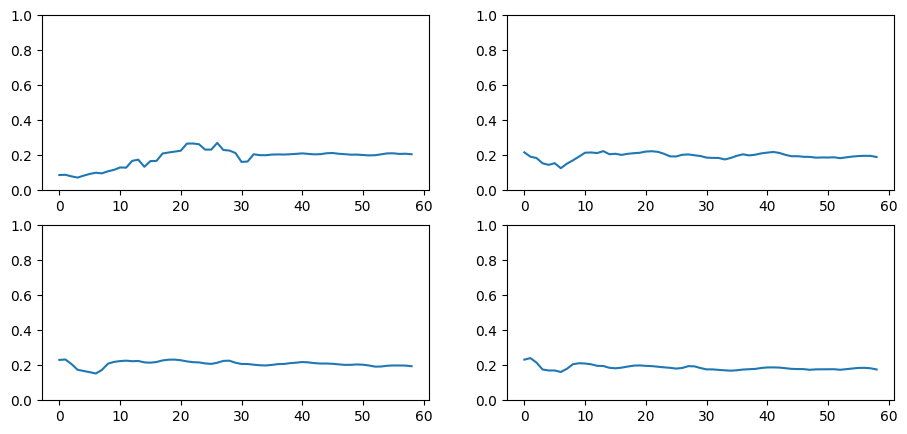

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.563,1.216,0,train
0.795,0.547,0,eval


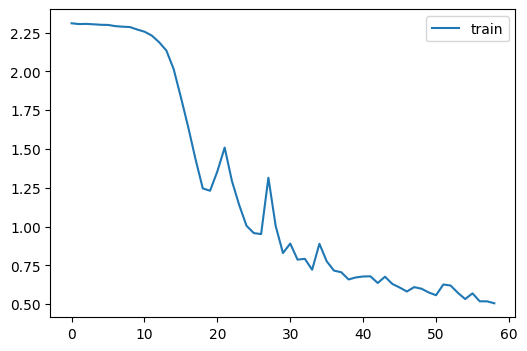

In [ ]:
reseed.set_seed(42)
model = get_model(act_gr)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

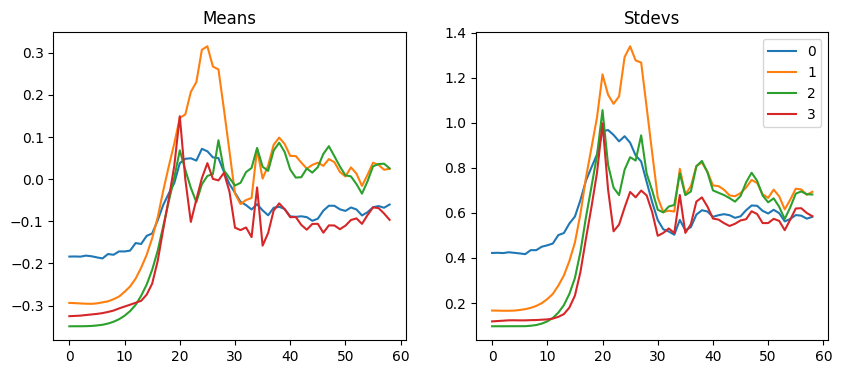

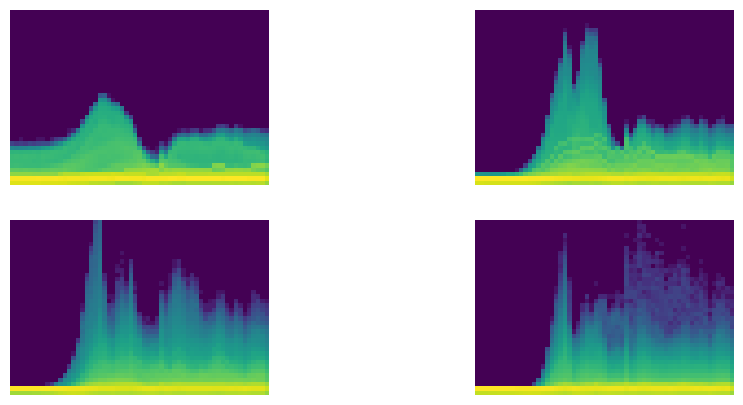

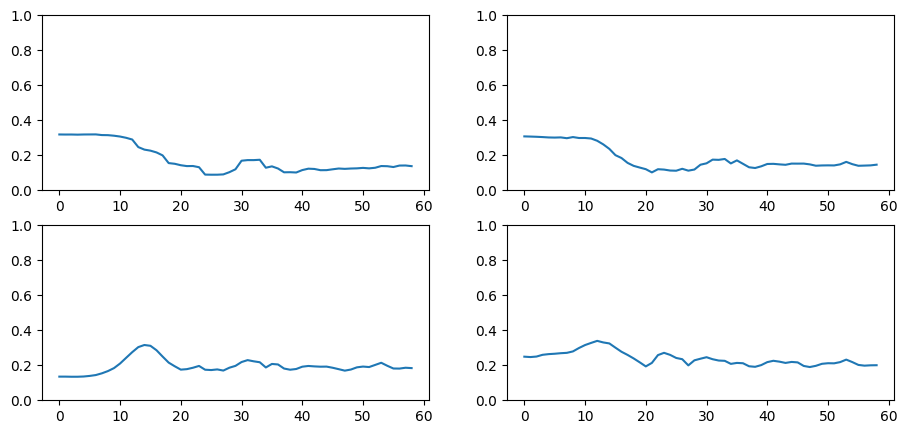

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.776,0.627,0,train
0.842,0.428,0,eval
0.867,0.362,1,train
0.859,0.383,1,eval
0.884,0.318,2,train
0.873,0.344,2,eval


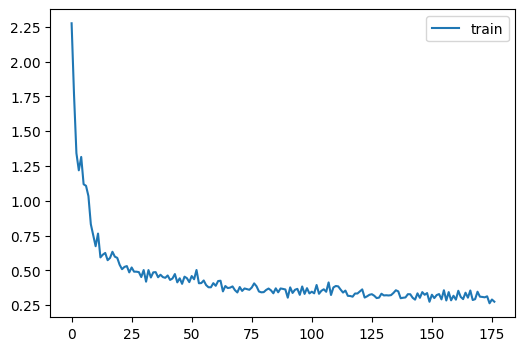

In [ ]:
reseed.set_seed(42)
model = get_model(act_gr).to('cpu').apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

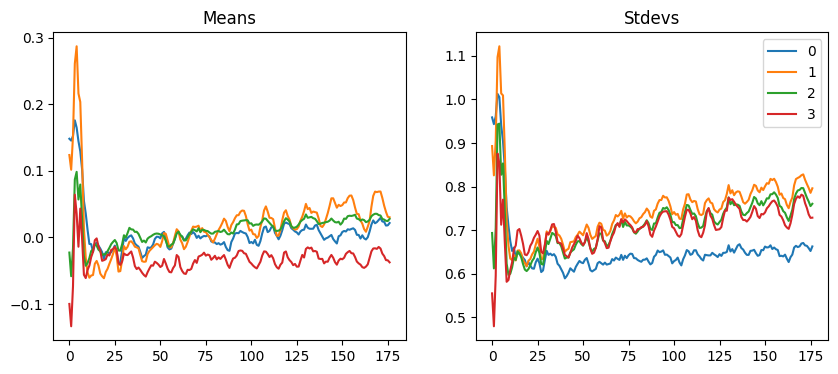

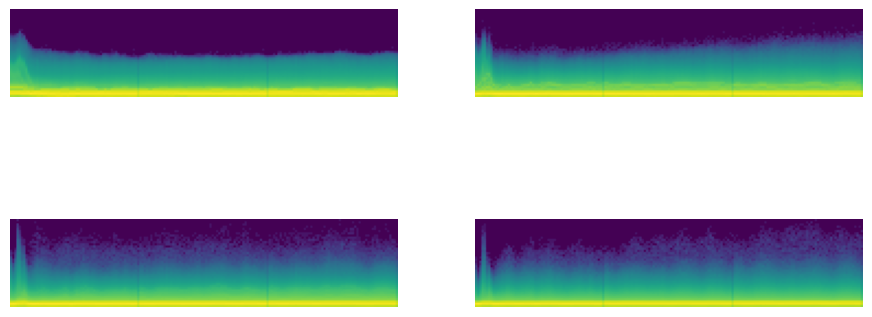

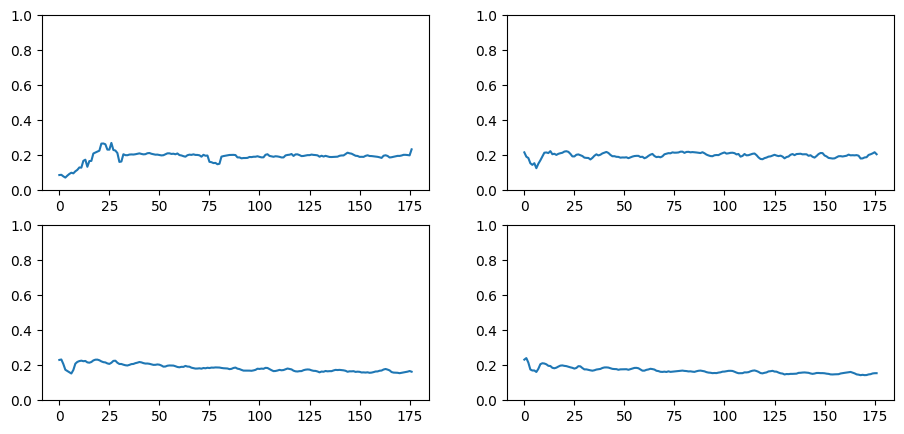

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

In [ ]:
#| export
def zero_bias(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        try:
            nn.init.zero_(m.bias)
        except AttributeError: pass
    

accuracy,loss,epoch,train
0.776,0.627,0,train
0.842,0.428,0,eval
0.867,0.362,1,train
0.859,0.383,1,eval
0.884,0.318,2,train
0.873,0.344,2,eval


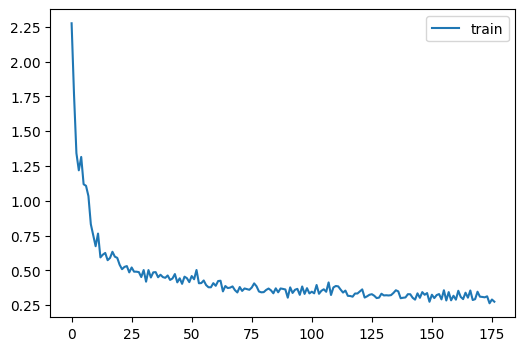

In [ ]:
reseed.set_seed(42)
model = get_model(act_gr).to('cpu').apply(zero_bias).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### LSUV as Callback
- we use gaussian init while lsuv uses orthonormal init
- they store activations after conv before relu, while we do so after relu (which is better for relu, but may not work for other activation functions)


In [ ]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

@no_grad()
def lsuv_init(model, m_act, m_in, xb, eps=1e-3, log=print, max_step=10):
    h = Hook(m_act, _lsuv_stats)
    log(f'LSUV: {m_in} {m_act if m_act!=m_in else ""}')
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>eps or abs(h.mean)>eps):
            log(f'LSUV: {h.mean} {h.std} {max_step}')
            if abs(h.mean) > eps: m_in.bias -= h.mean
            if abs(h.std-1) > eps: m_in.weight.data /= h.std
            max_step -= 1
            if max_step == 0: 
                break
        log(f'LSUV: {m_in} {h.mean} {h.std} {max_step}')
    h.remove()
    
def lsuv_layers(model):
    conv_lin = [o for o in model.modules() if isinstance(o, (nn.Conv2d, nn.Linear))]
    return zip(conv_lin, conv_lin)

class LSUVInit(Callback):
    def __init__(self, layers=None, eps=1e-3, verbose=False, cancel_fit=False, skip_last=0):
        """layers - a function that returns iterable of point of measurement and conv|linear to tweak"""
        self.layers = layers if layers is not None else lsuv_layers
        self.log = fc.noop if not verbose else print
        self.eps = eps
        self.cancel_fit = cancel_fit
        self.skip_last = -skip_last if skip_last != 0 else None
    
    def before_batch(self, learn):
        if getattr(learn.model, 'lsuv_init', False): return
        layers = list(self.layers(learn.model))
        xb, _ = learn.batch
        training = learn.model.training
        learn.model.train(False)
        for ms in layers[:self.skip_last]: 
            lsuv_init(learn.model, *ms, xb, eps=self.eps, log=self.log)
        learn.model.lsuv_init = True
        learn.model.train(training)
        print(f'LSUV init done on {len(layers)} layers')
        if self.cancel_fit: raise CancelFitException()


In [ ]:
def our_model_layers(model, last=True):
    relus = [o for o in model.modules() if isinstance(o, (GeneralRelu, nn.ReLU, nn.GELU))]
    convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
    if len(relus) < len(convs) and last:
        relus = relus + convs[len(relus):]
    return zip(relus,convs)
list(our_model_layers(get_model(act_gr)))

[(GeneralRelu(),
  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]

In [ ]:
list(our_model_layers(get_model(act_gr), last=False))

[(GeneralRelu(),
  Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))),
 (GeneralRelu(),
  Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]

accuracy,loss,epoch,train
0.774,0.636,0,train
0.845,0.427,0,eval
0.867,0.364,1,train
0.858,0.382,1,eval
0.882,0.324,2,train
0.866,0.360,2,eval


LSUV init [(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) GeneralRelu()
LSUV: 0.14819078147411346 0.9588143229484558 10
LSUV: 0.09629515558481216 0.949985146522522 9
LSUV: 0.07919186353683472 0.9693475961685181 8
LSUV: 0.06004340946674347 0.9757617712020874 7
LSUV: 0.046904489398002625 0.9824097752571106 6
LSUV: 0.03624549135565758 0.9865425825119019 5
LSUV: 0.028318628668785095 0.9897582530975342 4
LSUV: 0.022095125168561935 0.9921059012413025 3
LSUV: 0.012072714976966381 0.9849966764450073 2
LSUV: 0.016548464074730873 0.9981837272644043 1
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) 0.016548464074730873 0.9981

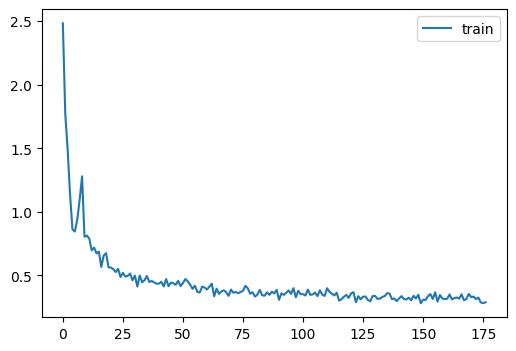

In [ ]:
reseed.previous()
model = get_model(act_gr).to('cpu').apply(zero_bias).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3, cbs=LSUVInit(partial(our_model_layers, last=False), verbose=True, eps=0.01))b

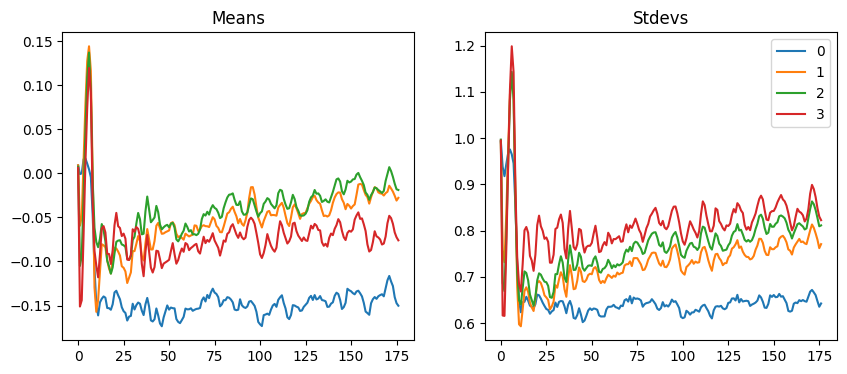

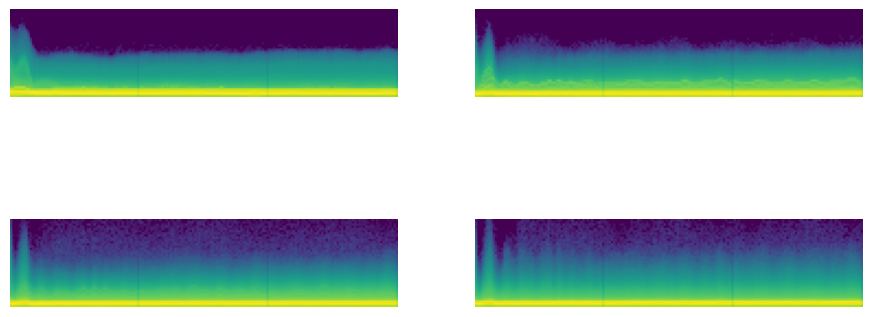

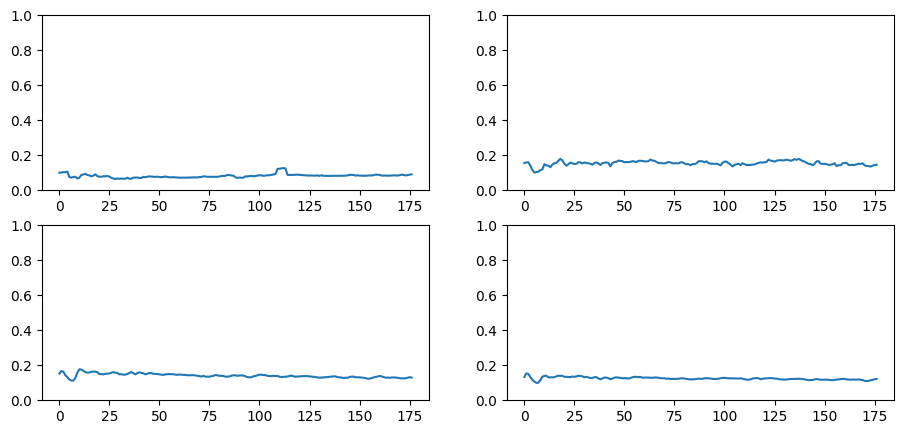

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.766,0.662,0,train
0.846,0.432,0,eval
0.870,0.362,1,train
0.867,0.367,1,eval
0.883,0.319,2,train
0.875,0.351,2,eval


LSUV init [(Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) 
LSUV: 0.012574740685522556 1.524409294128418 10
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) -0.00201274361461401 1.0192599296569824 9
LSUV: Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) 
LSUV: 0.1119

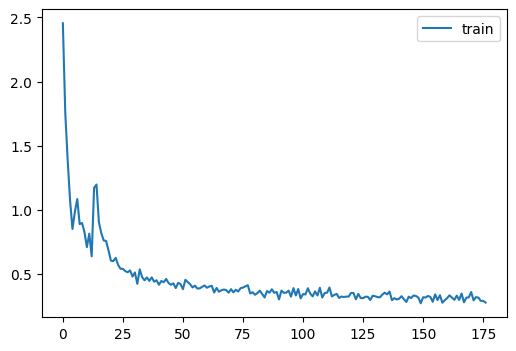

In [ ]:
reseed.previous()
model = get_model(act_gr).to('cpu').apply(zero_bias).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3, cbs=LSUVInit(None, verbose=True, eps=0.1))

accuracy,loss,epoch,train
0.757,0.698,0,train
0.844,0.437,0,eval
0.868,0.365,1,train
0.865,0.371,1,eval
0.884,0.319,2,train
0.876,0.344,2,eval


LSUV init [(Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))), (Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) 
LSUV: 0.012574740685522556 1.524409294128418 10
LSUV: -0.014587468467652798 1.019260048866272 9
LSUV: -0.0005256556905806065 1.0012609958648682 8
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) -0.0005600146832875907 1.000

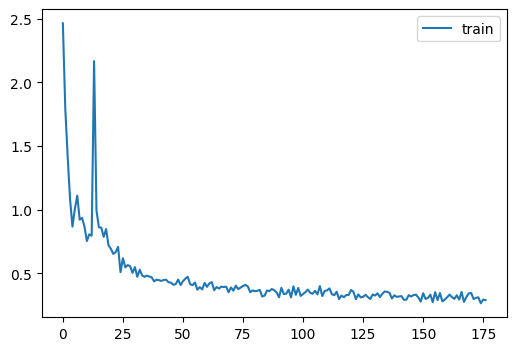

In [ ]:
reseed.previous()
model = get_model(act_gr).to('cpu').apply(zero_bias).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3, cbs=LSUVInit(None, verbose=True, eps=0.001))

### Orthonormal pre-init as pointed out in the paper (from pytorch-lsuv)


In [ ]:
#|export
# Orthonorm init code is taken from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(shape):
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)#w;
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q.astype(np.float32)
# https://github.com/ducha-aiki/LSUV-pytorch  
def orthogonal_init_paper(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            w_ortho = svd_orthonormal(m.weight.shape)
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
    return


accuracy,loss,epoch,train
0.765,0.663,0,train
0.840,0.442,0,eval
0.861,0.381,1,train
0.854,0.396,1,eval
0.878,0.333,2,train
0.859,0.380,2,eval


LSUV init done on 5 layers


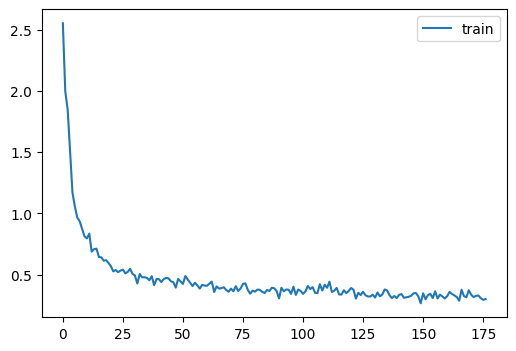

In [ ]:
reseed.previous()
model=get_model(act_gr).apply(orthogonal_init_paper)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(our_model_layers, eps=0.001, verbose=False)])
learn.fit(3)

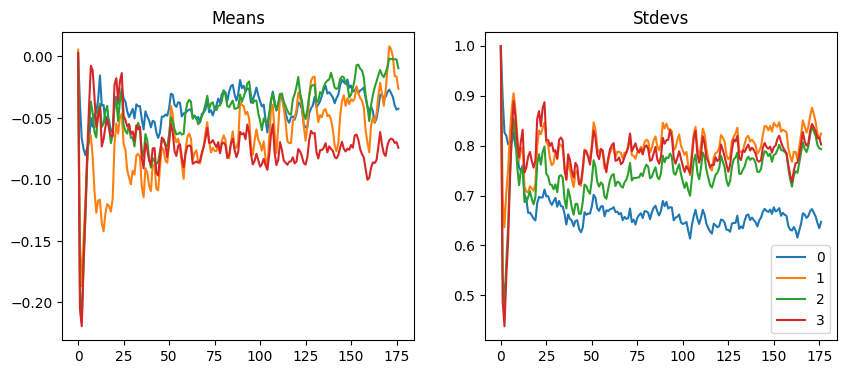

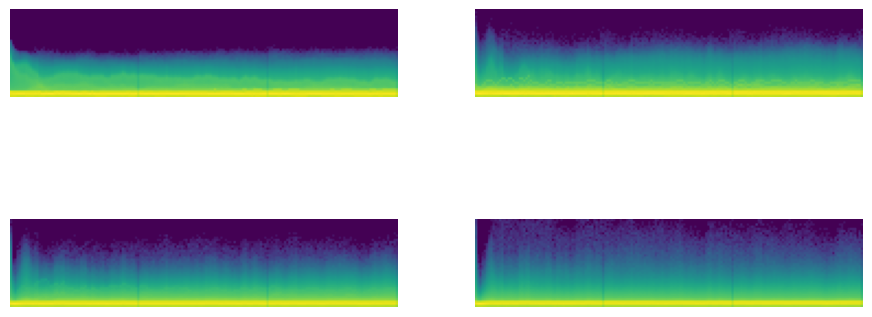

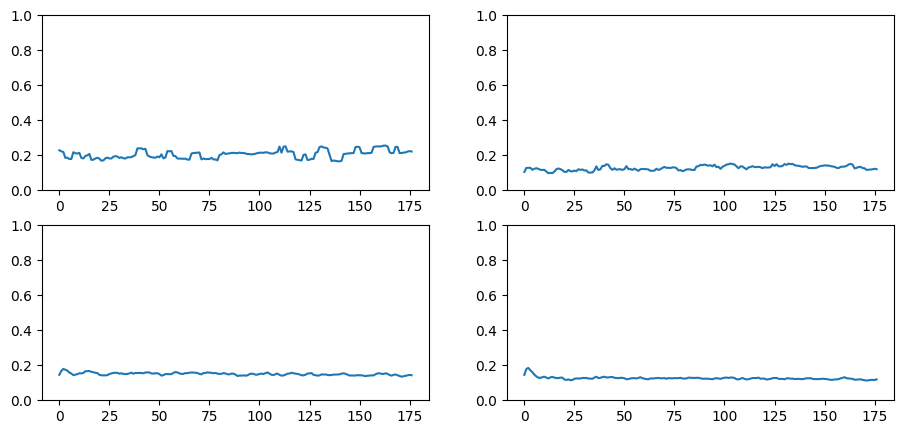

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.765,0.663,0,train
0.840,0.442,0,eval
0.861,0.381,1,train
0.854,0.396,1,eval
0.878,0.333,2,train
0.859,0.380,2,eval


LSUV init done on 5 layers


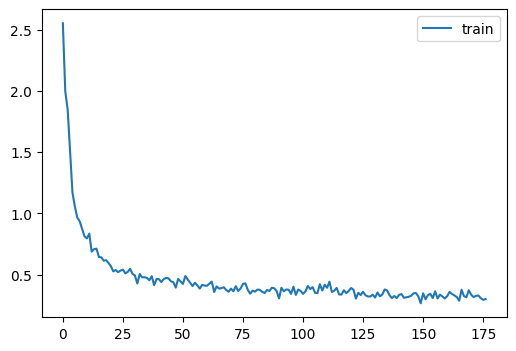

In [ ]:
reseed.previous()
model=get_model(act_gr).apply(orthogonal_init_paper)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(our_model_layers, eps=0.001, verbose=False)])
learn.fit(3)

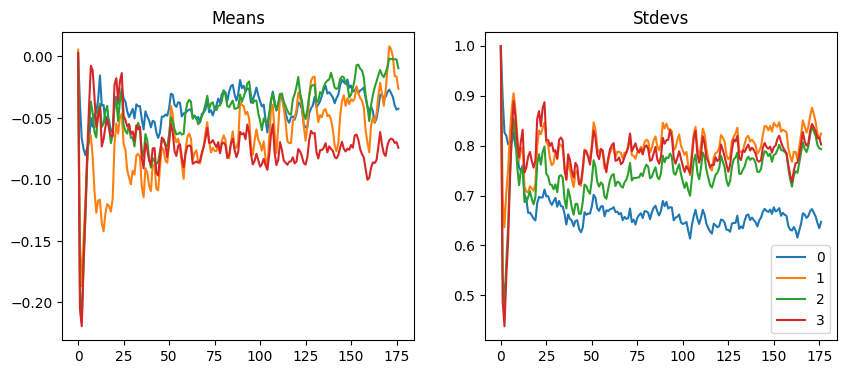

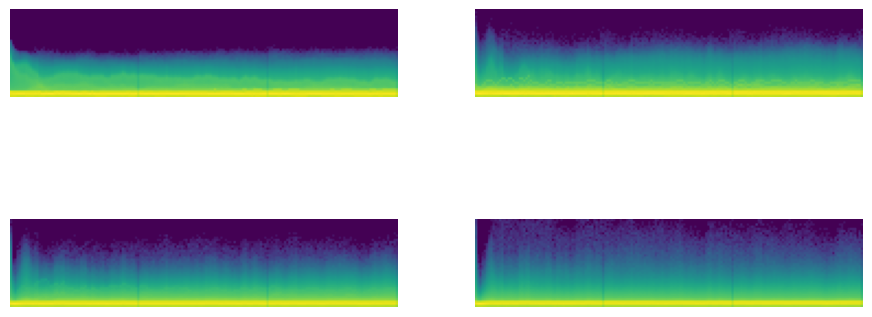

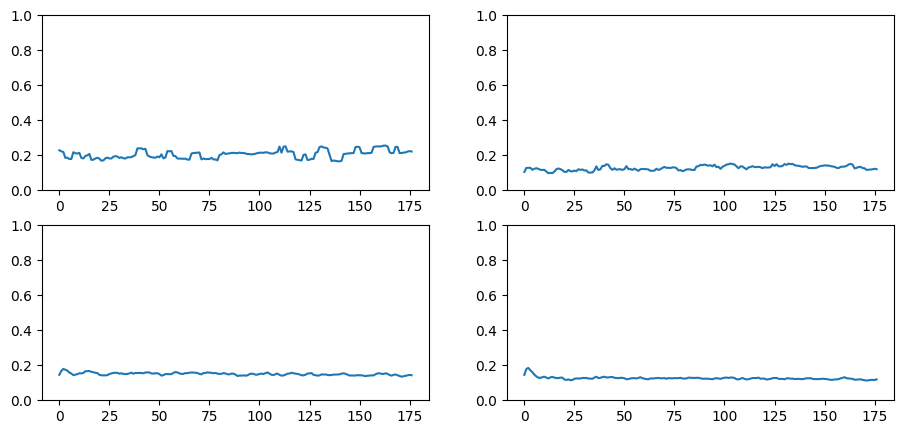

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.765,0.656,0,train
0.836,0.450,0,eval
0.862,0.376,1,train
0.852,0.409,1,eval
0.878,0.332,2,train
0.859,0.388,2,eval


LSUV init done on 5 layers


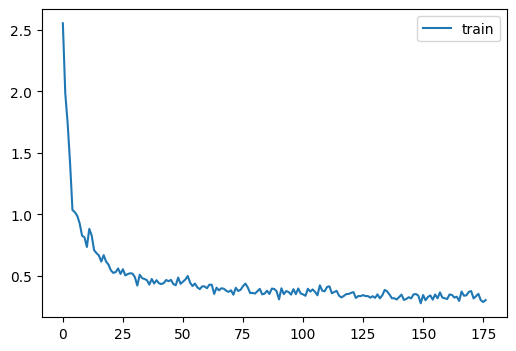

In [ ]:
reseed.previous()
model=get_model(act_gr).apply(orthogonal_init_paper)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.0001, verbose=False)])
learn.fit(3)

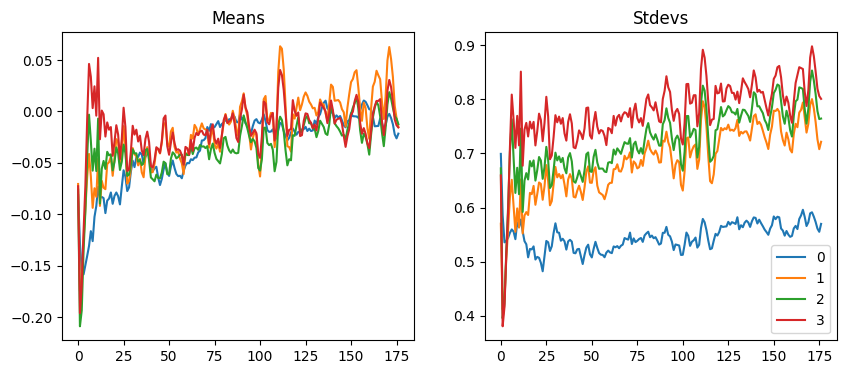

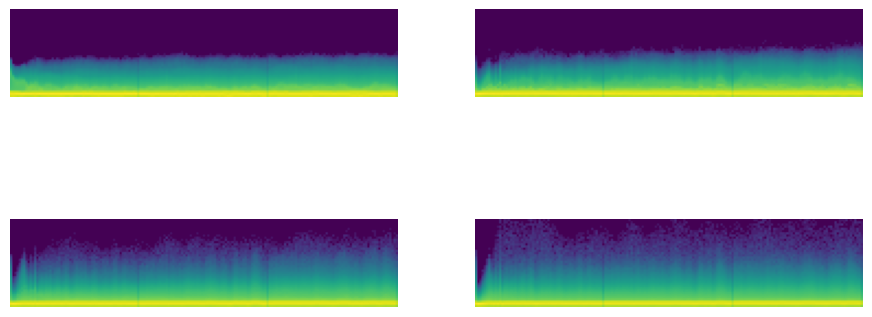

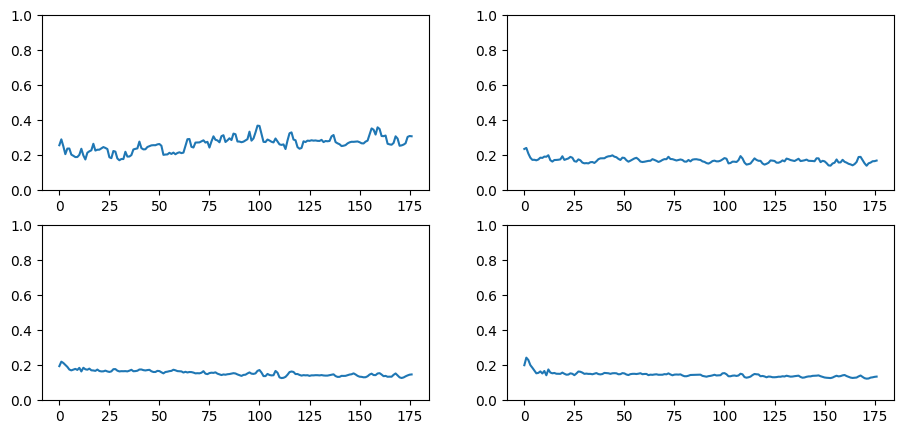

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

### Orthonormal pre-init as pointed out in the paper (using pytorch implementation of Saxe, A. et al. (2013))


In [ ]:
#|export
def orthogonal_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            nn.init.orthogonal_(m.weight)
            try: nn.init.constant_(m.bias, 0)
            except AttributeError: pass

/opt/homebrew/Caskroom/mambaforge/base/envs/miniai/lib/python3.10/site-packages/torch/nn/init.py:484: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  q, r = torch.linalg.qr(flattened)


accuracy,loss,epoch,train
0.768,0.652,0,train
0.844,0.437,0,eval
0.861,0.376,1,train
0.863,0.383,1,eval
0.879,0.330,2,train
0.870,0.361,2,eval


LSUV init done on 5 layers


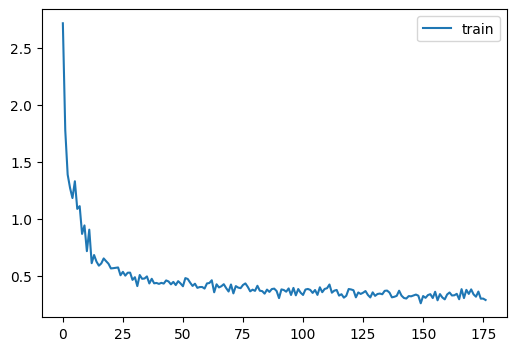

In [ ]:
reseed.previous()
model=get_model(act_gr).apply(orthogonal_init)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.001, verbose=False)])
learn.fit(3)

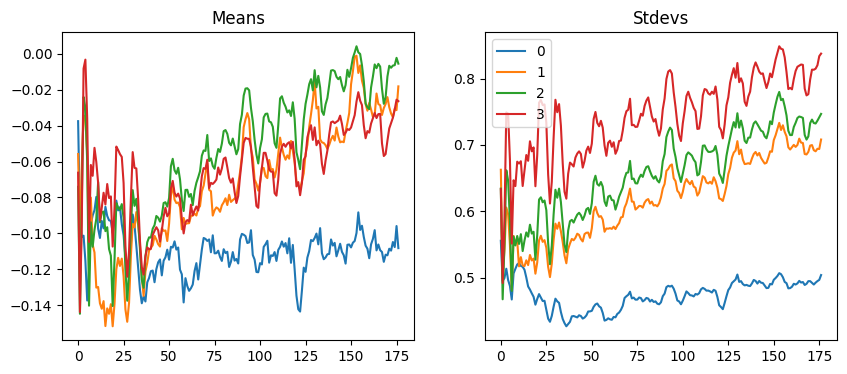

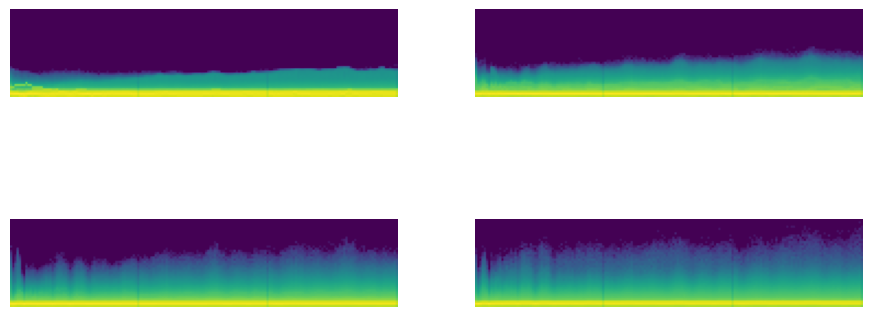

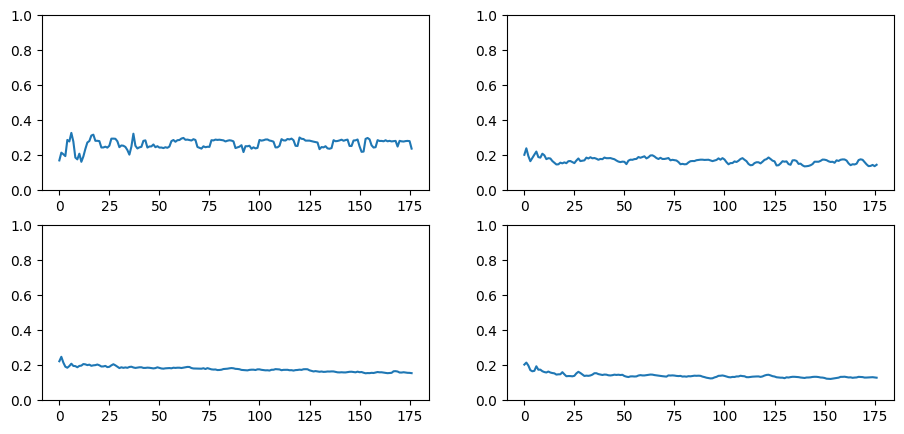

In [ ]:

astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.719,0.799,0,train
0.837,0.447,0,eval
0.862,0.376,1,train
0.866,0.378,1,eval
0.880,0.324,2,train
0.871,0.356,2,eval


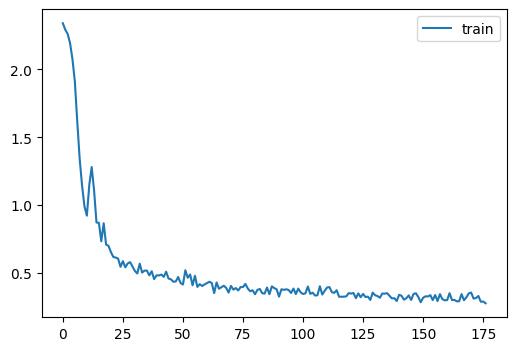

In [ ]:
reseed.previous()
model=get_model(act_gr).apply(orthogonal_init)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()